In [1]:
import numpy as np
import matplotlib.pyplot as plt

from argosim.antenna_utils import *
from argosim.plot_utils import *
from argosim.data_utils import *
from argosim.clean import *
from argosim.imaging_utils import *

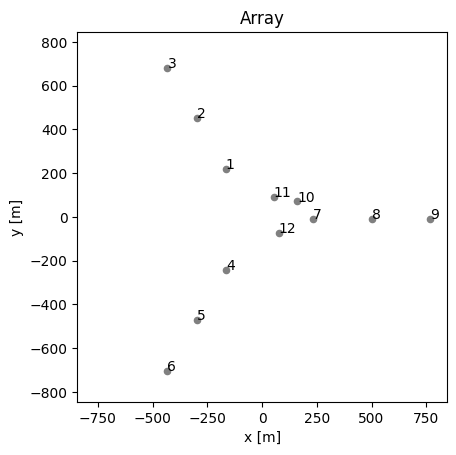

In [2]:
# Antenna parameters
e_lim = 400
n_lim = 400
n_antenna = 3
n_baselines = n_antenna*(n_antenna-1)
radius = 800
alpha = 120

arr_y = y_antenna_arr(n_antenna, radius, alpha)
arr_center = random_antenna_arr(n_antenna=n_antenna, E_lim=e_lim, N_lim=n_lim)
arr = combine_antenna_arr(arr_y,arr_center)
plot_antenna_arr(arr)

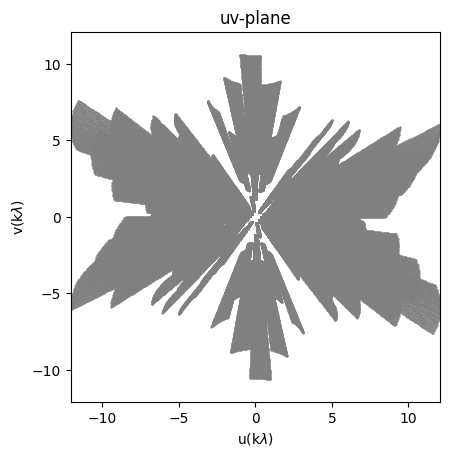

In [3]:
# Source tracking parameters
source_decl = -30/180*np.pi
array_lat = 10.7/180*np.pi
track_time = 2
delta_t = 5/60 # 300 secs
t_0 = -0.5
n_times = int(track_time/delta_t)

# Multiband parameters
f = 2000e6 # 1200 MHz
bandwidth = 2000e6
n_freqs = 128

# Get baselines
base_arr = get_baselines(arr)
track, _ = uv_track_multiband(base_arr, array_lat, source_decl, track_time, t_0, n_times, f, bandwidth, n_freqs)
plot_baselines(track)

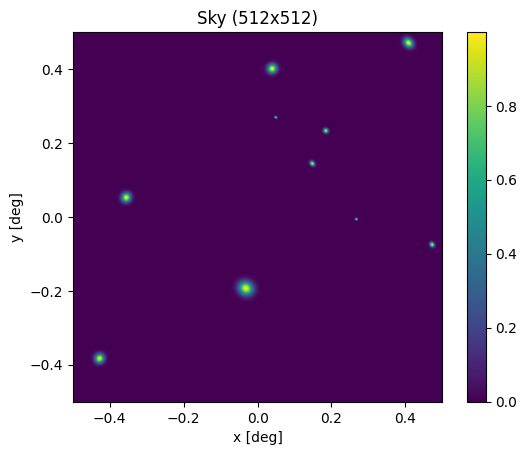

In [4]:
Npx = 512
fov_size = (1., 1.) # max 3 degrees FOV from 6 m parabolic dishes.
deg_size_list = np.array([.03, .02, .02, .02, .02, .01, .01, .01, .005, .005])
source_intensity_list = [1]*len(deg_size_list)
sky = n_source_sky((Npx, Npx), fov_size[0], deg_size_list, source_intensity_list, seed=39807)
plot_sky(sky, fov_size)

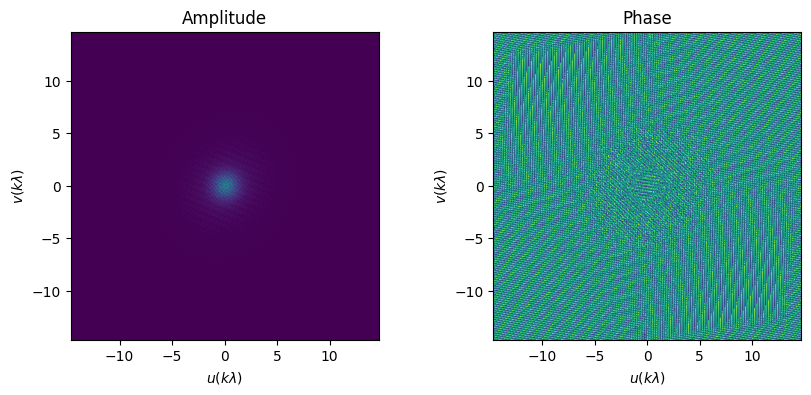

In [5]:
# Fourier transform of the sky
sky_uv = sky2uv(sky)
plot_sky_uv(sky_uv, fov_size)

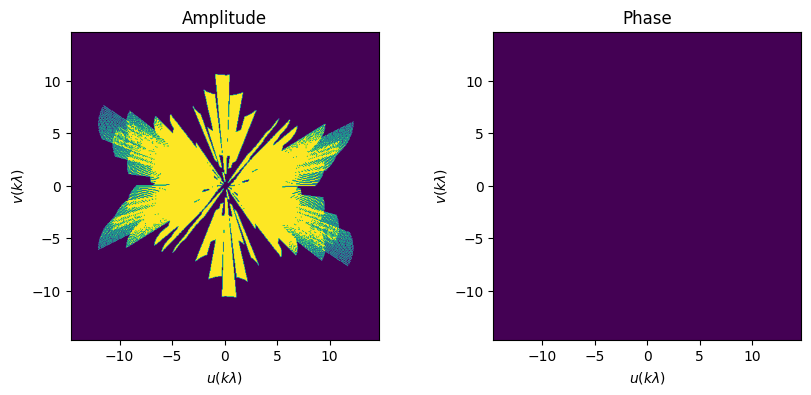

In [6]:
# Fourier transform of the mask
uv_plane_mask, uv_sample_indices = grid_uv_samples(track, sky_uv.shape, fov_size)
plot_sky_uv(uv_plane_mask, fov_size)

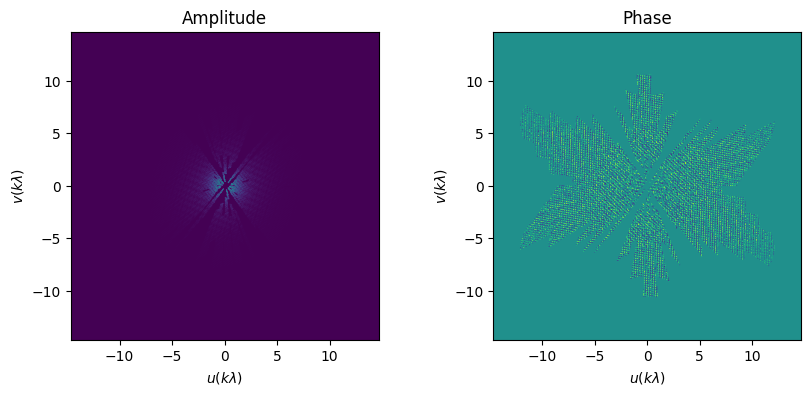

In [7]:
# Visibilities
vis = compute_visibilities_grid(sky_uv, uv_plane_mask)
plot_sky_uv(vis, fov_size=fov_size)

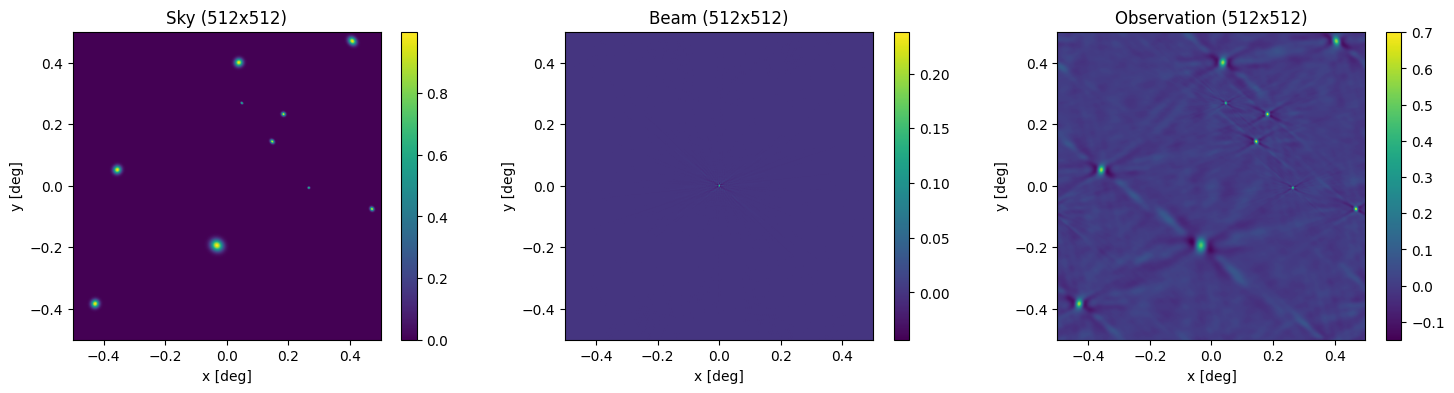

In [8]:
obs = uv2sky(vis)
beam = uv2sky(uv_plane_mask)

fig, ax = plt.subplots(1, 3, figsize=(18,4))
plot_sky(sky, fov_size, ax[0], fig, 'Sky')
plot_sky(beam, fov_size, ax[1], fig, 'Beam')
plot_sky(obs, fov_size, ax[2], fig, 'Observation')

Beam size:

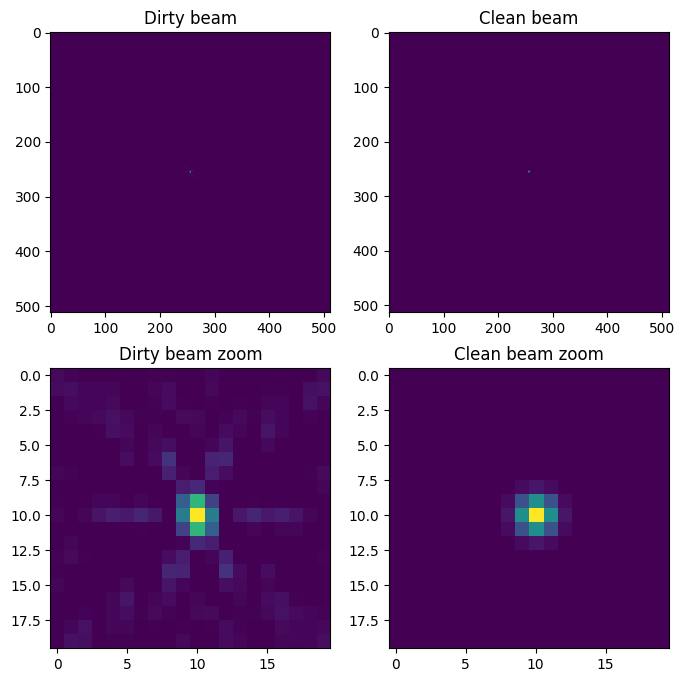

In [9]:
B_norm = beam/np.max(beam)
clean_beam_size_px = 2
# Get the clean beam
B_clean = gauss_source(Npx+1, Npx+1, np.array([0,0]), fwhm_pix=clean_beam_size_px)

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.imshow(B_norm, vmin=0, vmax=1)
plt.title('Dirty beam')
plt.subplot(2,2,2)
plt.imshow(B_clean, vmin=0, vmax=1)
plt.title('Clean beam')
plt.subplot(2,2,3)
plt.imshow(B_norm[Npx//2-10:Npx//2+10,Npx//2-10:Npx//2+10], vmin=0, vmax=1)
plt.title('Dirty beam zoom')
plt.subplot(2,2,4)
plt.imshow(B_clean[Npx//2-10:Npx//2+10,Npx//2-10:Npx//2+10], vmin=0, vmax=1)
plt.title('Clean beam zoom')
plt.show()

# Hogbom's Clean 

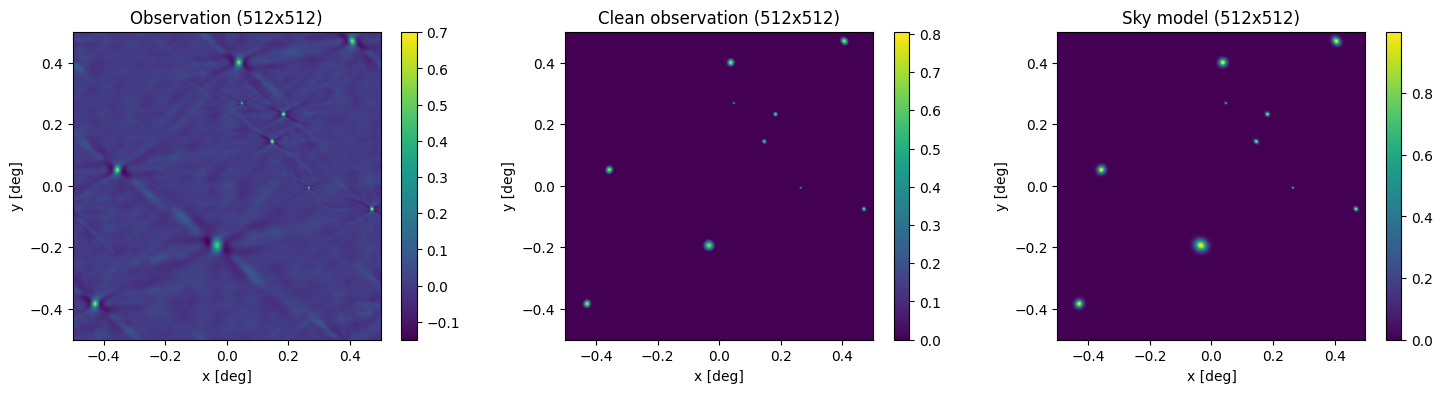

In [10]:
I_clean, sky_model = clean_hogbom(obs, beam, 0.3, 1000, 1e-3 , clean_beam_size_px=2, res=False)
# Plot clean observation
fig, ax = plt.subplots(1, 3, figsize=(18,4))
plot_sky(obs, fov_size, ax[0], fig, 'Observation')
plot_sky(I_clean, fov_size, ax[1], fig, 'Clean observation')
plot_sky(sky, fov_size, ax[2], fig, 'Sky model')

# plt.savefig('/home/figures/clean_observation.pdf')
plt.show()

# Add noise

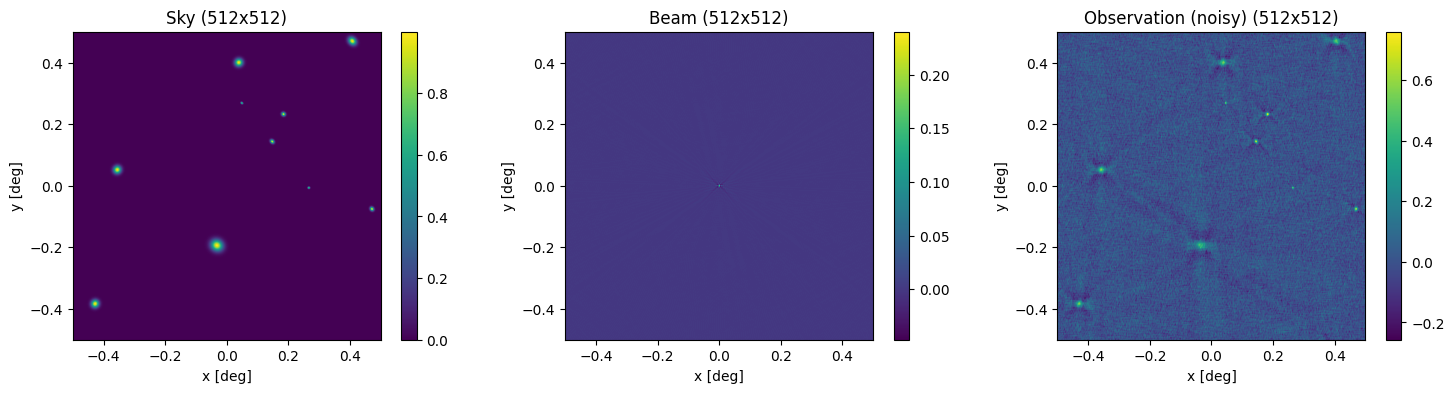

In [22]:
sigma = 0.1

vis_noisy = add_noise_uv(vis, uv_plane_mask, sigma)
obs_noisy = uv2sky(vis_noisy)

fig, ax = plt.subplots(1, 3, figsize=(18,4))
plot_sky(sky, fov_size, ax[0], fig, 'Sky')
plot_sky(beam, fov_size, ax[1], fig, 'Beam')
plot_sky(obs_noisy, fov_size, ax[2], fig, 'Observation (noisy)')

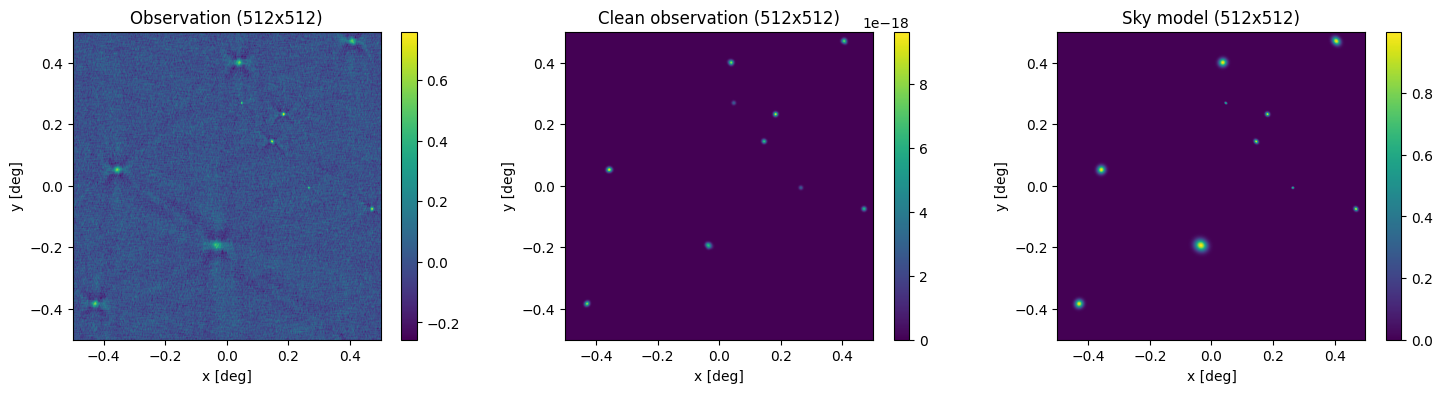

In [26]:
I_clean, sky_model = clean_hogbom(obs_noisy, beam, 0.3, 500, 1e-3 , clean_beam_size_px=5, res=False)
# Plot clean observation
fig, ax = plt.subplots(1, 3, figsize=(18,4))
plot_sky(obs_noisy, fov_size, ax[0], fig, 'Observation')
plot_sky(I_clean, fov_size, ax[1], fig, 'Clean observation')
plot_sky(sky, fov_size, ax[2], fig, 'Sky model')

# plt.savefig('/home/figures/clean_observation.pdf')
plt.show()